In [1]:
!pip install langchain_core langchain_openai langgraph supabase streamlit

  Using cached altair-5.5.0-py3-none-any.whl.metadata (11 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached GitPython-3.1.43-py3-none-any.whl.metadata (13 kB)
  Using cached pydeck-0.9.1-py2.py3-none-any.whl.metadata (4.1 kB)
  Using cached jsonschema-4.23.0-py3-none-any.whl.metadata (7.9 kB)
  Using cached gitdb-4.0.11-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.1-py3-none-any.whl.metadata (4.3 kB)
  Using cached jsonschema_specifications-2024.10.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached referencing-0.35.1-py3-none-any.whl.metadata (2.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 49.6 MB/s eta 0:00:0000:0100:01
Using cached altair-5.5.0-py3-none-any.whl (731 kB)
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)
Using cached GitPython-3.1.43-py3-none-any.whl (207 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.6/29.6 MB 50.1 MB/s eta 0:00:000

In [2]:
# RPC
def get_reservations_by_phone(phone: str) -> dict:
    response = supabase.rpc("get_reservations_by_phone", {"phone_number": phone}).execute()
    # ret = json.loads(response.data)
    # return ret
    return response.data

def update_reservation_date(
    reservation_uuid: str, new_date: str
) :
    response = supabase.rpc("update_reservation_date", {"reservation_uuid": reservation_uuid, "new_reservation_date": new_date}).execute()
    return "reservation successfully updated"

def cancel_reservation(reservation_uuid: str) -> dict:
    response = supabase.rpc("cancel_reservation", {"reservation_uuid": reservation_uuid}).execute()
    return "reservation successfully cancelled"

In [3]:
# Annotated: TypedHinting + 메타데이터 첨부
from typing import Annotated
from typing_extensions import TypedDict

# add_messages: 두개의 메시지 리스트 합병. id 가 같을 시 덮어씀
# AnyMessage: All messages like AIMessage, HumanMessage, ToolMessage ...
from langgraph.graph.message import add_messages, AnyMessage

class ReservState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str

In [4]:
# pydantic: parsing library, 출력 모델의 유형과 제약 조건 보장
from pydantic import BaseModel, Field

class RequestAssistance(BaseModel):
    """
    Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.
    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """
    request: str

In [5]:
# utils
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolNode

def handle_tool_error(state) -> dict:
  error = state.get("error")
  tool_calls = state["messages"][-1].tool_calls
  return {
    "messages": [
      ToolMessage(
        content=f"Error: {repr(error)}\n please fix your mistakes.",
        tool_call_id=tc["id"],
      )
      for tc in tool_calls
    ]
  }

def create_tool_node_with_fallback(tools: list) -> dict:
  # ToolNode: 도구를 실행하는 노드
  # with_fallbacks: 예외처리
  return ToolNode(tools).with_fallbacks(
      [RunnableLambda(handle_tool_error)], exception_key="error"
  )

def _print_event(event: dict, _printed: set, max_length=1500):
  current_state = event.get("dialog_state")
  if current_state:
    print("Currently in: ", current_state[-1])
  message = event.get("messages")
  if message:
    if isinstance(message, list):
      message = message[-1]
    if message.id not in _printed:
      msg_repr = message.pretty_repr(html=True)
      if len(msg_repr) > max_length:
        msg_repr = msg_repr[:max_length] + " ... (truncated)"
      print(msg_repr)
      _printed.add(message.id)

In [6]:
from langchain_core.runnables import RunnableConfig
from langchain.tools import tool

@tool
def fetch_user_info(config: RunnableConfig) -> list[dict]:
  """Fetch all user info using RunnableConfig"""
  configuration = config.get("configurable", {})
  phone_number = configuration.get("phone_number", None)
  if not phone_number:
    raise ValueError("No phone number configured.")

  return []

In [7]:
from langchain.tools import Tool

# Tool to get reservations by phone
search_reservation = Tool(
    name="GetReservationsByPhone",
    func=lambda phone: get_reservations_by_phone(phone),
    description=(
        "Retrieve reservations based on a phone number. "
        "Input: a phone number as a string. Output: reservation details."
    )
)

# Tool to update reservation date
update_reservation = Tool(
    name="UpdateReservationDate",
    func=lambda reservation_uuid, new_date: update_reservation_date(reservation_uuid, new_date),
    description=(
        "Update the date of an existing reservation. "
        "Input: reservation_uuid (str), new_date (str in format YYYY-MM-DD). "
        "Output: Success message."
    )
)

# Tool to cancel a reservation
delete_reservation = Tool(
    name="CancelReservation",
    func=lambda reservation_uuid: cancel_reservation(reservation_uuid),
    description=(
        "Cancel an existing reservation based on its UUID. "
        "Input: reservation_uuid (str). Output: Success message."
    )
)

primary_safe_tools = [search_reservation]
primary_sensitive_tools = [update_reservation, delete_reservation]
primary_sensitive_tool_names = {t.name for t in primary_sensitive_tools}

tools = primary_safe_tools + primary_sensitive_tools
print(len(tools))

3


In [8]:
from langchain.tools import Tool

# Tool to get reservations by phone
search_reservation = Tool(
    name="GetReservationsByPhone",
    func=lambda phone: get_reservations_by_phone(phone),
    description=(
        "Retrieve reservations based on a phone number. "
        "phone number is get from config: configurable: phone_number"
        "Input: a phone number as a string. Output: reservation details."
        "if reservation data is empty stop find resercation data"
    )
)

# Tool to update reservation date
update_reservation = Tool(
    name="UpdateReservationDate",
    func=lambda reservation_uuid, new_date: update_reservation_date(reservation_uuid, new_date),
    description=(
        "Update the date of an existing reservation. "
        "Input: reservation_uuid (str), new_date (str in format YYYY-MM-DD). "
        "Output: Success message."
    )
)

# Tool to cancel a reservation
delete_reservation = Tool(
    name="CancelReservation",
    func=lambda reservation_uuid: cancel_reservation(reservation_uuid),
    description=(
        "Cancel an existing reservation based on its UUID. "
        "Input: reservation_uuid (str). Output: Success message."
    )
)

In [9]:
from langchain_core.runnables import Runnable, RunnableConfig

class Assistant:
  def __init__(self, runnable: Runnable):
    self.runnable = runnable

  def __call__(self, state: ReservState, config: RunnableConfig):
    while True:
      result = self.runnable.invoke(state, config=config)

      if not result.tool_calls and (
          not result.content
          or isinstance(result.content, list)
          # 설명 필요
          and not result.content[0].get("text")
      ):
        messages = state["messages"] + [("user", "Respond with a real output.")]
        state = {**state, "messages": messages}
      else:
        break
    return {"messages": result}

In [10]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

from datetime import date, datetime

llm = ChatOpenAI(model="gpt-4o-mini", temperature=1)

# 현재를 기준으로 실시간 답변을 지원하기 위해 datetime.now를 partial로 부분적 받음
assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Reservation Service. "
            " Use the provided tools to search reservations, add reservation, update reservation and delete reservation"
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

assistant_runnable = assistant_prompt | llm.bind_tools(tools)


In [11]:
from re import M
from typing import Literal

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition

builder = StateGraph(ReservState)

# user_info 실행, Config 객체가 비어있으면?
def user_info(state: ReservState):
  return {"user_info": fetch_user_info.invoke({})}

builder.add_node("fetch_user_info", user_info)
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("primary_safe_tools", create_tool_node_with_fallback(primary_safe_tools))
builder.add_node("primary_sensitive_tools", create_tool_node_with_fallback(primary_sensitive_tools))

builder.add_edge(START, "fetch_user_info")
builder.add_edge("fetch_user_info", "assistant")

def route_tools(state: ReservState):
  next_node = tools_condition(state)
  if next_node == END:
    return END
  ai_message = state["messages"][-1]

  first_tool_call = ai_message.tool_calls[0]
  if first_tool_call["name"] in primary_sensitive_tool_names:
    return "primary_sensitive_tools"
  return "primary_safe_tools"

builder.add_conditional_edges(
  "assistant", route_tools, ["primary_safe_tools", "primary_sensitive_tools", END]
)
builder.add_edge("primary_safe_tools", "assistant")
builder.add_edge("primary_sensitive_tools", "assistant")

memory = MemorySaver()
graph = builder.compile(
    checkpointer=memory,
    interrupt_before=["primary_sensitive_tools"],
)


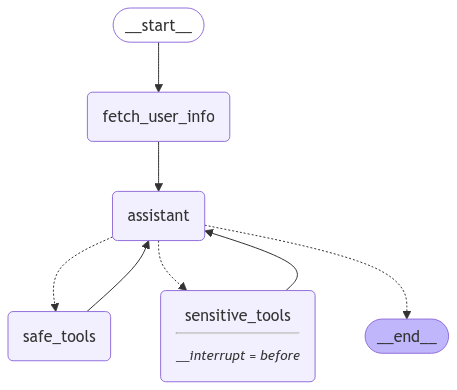

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
import uuid

thread_id = str(uuid.uuid4())

config = {
  "configurable": {
    "phone_number": "",
    "thread_id": thread_id
  }
}

### 1. 예약 검색, 수정, 삭제 신뢰성 있게 구현하기
### 2. 사용자 정보 미리 받고 tool들과 내용 겹치지 않도록 하기
### 3. config 활용 방법 생각하기

In [13]:

def get_first_user_info():
  if config["configurable"]["phone_number"] != None:
    config["configurable"]["phone_number"] = input("Plz Enter your phone number: ")

get_first_user_info()

print(config)

while True:
  question = input("Hello! Enter the question: ")

  if question in ['q']:
    break
  _printed = set()

  events = graph.stream(
      {"messages": ("user", question)}, config, stream_mode="values"
  )
  for event in events:
    _print_event(event, _printed)

  snapshot = graph.get_state(config)

  while snapshot.next:
    try:
      user_input = input(
          "다음의 행동에 동의하십니까? 동의하시면 'y'를 입력해주세요."
          "만약 동의하지 않는다면 다른 답변을 입력해주시기 바랍니다.\n\n"
      )
    except:
      user_input='y'
    if user_input.strip() == 'y':
      result = graph.invoke(
          None,
          config,
      )
    else:
      result = graph.invoke(
        {
          "messages": [
            ToolMessage(
              tool_call_id=event["messages"][-1].tool_calls[0]["id"],
              content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
            )
          ]
        },
        config,
      )
    snapshot = graph.get_state(config)



{'configurable': {'phone_number': 'ㅂ', 'thread_id': '7c832103-5997-4d90-809a-dc07c90c6f74'}}


In [ ]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
  # This requires some extra dependencies and is optional
  pass